In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/My\ Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [0]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
import scipy.spatial
import json
from matplotlib import cm as CM
from image import *
from model import CSRNet
import torch
import torchvision.transforms.functional as F
import time
import random
import math

from torchvision import datasets, transforms
transform=transforms.Compose([
                       transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
                   ])



#this is borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet
def gaussian_filter_density(gt):
    gsstart = time.time()
    ##print(gt.shape)
    ##print(len(np.nonzero(gt)[1])==len(np.nonzero(gt)[0]))
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density
    pts = np.array(list(zip(np.nonzero(gt)[1],np.nonzero(gt)[0])))
    #print('pts',np.shape(pts))
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print('done.')
    gsend = time.time()
    gtime = (math.ceil((gsend-gsstart)*100))/100
    print('gaussion need {}sec'.format(gtime))
    return density






#set the root to the Shanghai dataset you download
root = '/content/drive/My Drive/Colab Notebooks/ShanghaiTech_Crowd_Counting_Dataset'




#now generate the ShanghaiA's ground truth
part_A_train = os.path.join(root,'part_A_final/train_data','images')
part_A_test = os.path.join(root,'part_A_final/test_data','images')
part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B_final/test_data','images')
path_sets = [part_A_test]

img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

x = random.randint(0,len(img_paths)-1)


img_path = img_paths[x]
mainstart = time.time()
mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
img= plt.imread(img_path)
k = np.zeros((img.shape[0],img.shape[1]))
gt = mat["image_info"][0,0][0,0][0]
for i in range(0,len(gt)):
    if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
        k[int(gt[i][1]),int(gt[i][0])]=1
k = gaussian_filter_density(k)
mainend = time.time()
maintime = (math.ceil((mainend-mainstart)*100))/100
print('generate a density map through traditional way need {}sec'.format(maintime))

######################################################################
######################################################################

model = CSRNet()
model = model.cuda()
netstart = time.time()
checkpoint = torch.load('best55epochmodel_best.pth.tar')
model.load_state_dict(checkpoint['state_dict'])
img = 255.0 * F.to_tensor(Image.open(img_paths[x]).convert('RGB'))
img = img.cuda()
img = transform(Image.open(img_paths[x]).convert('RGB')).cuda()
    
output = model(img.unsqueeze(0))

output = output.detach().cpu().numpy()
output = np.squeeze(output)
output = np.squeeze(output)
netend = time.time()
nettime = (math.ceil((netend-netstart)*100))/100
print('Generate a density map through netword need {}sec'.format(nettime))



generate density...
done.
gaussion need 10.78sec
generate a density map through traditional way need 13.93sec


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



Generate a density map through netword need 3.92sec


generate a density map through traditional way need 13.93sec
Generate a density map through netword need 3.92sec


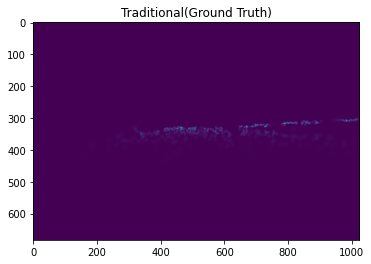

In [0]:
print('generate a density map through traditional way need {}sec'.format(maintime))
print('Generate a density map through netword need {}sec'.format(nettime))
plt.title('Traditional(Ground Truth)')
plt.imshow(k)

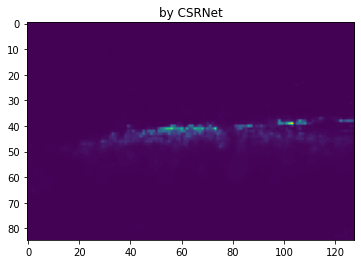

In [0]:
plt.title('by CSRNet')
plt.imshow(output)